In [39]:
# ============================================================================
# LOAD DATA DARI TAHAP 3 (SOLUSI NAMEERROR)
# ============================================================================
import pandas as pd

# 1. Load data training dan testing yang sudah disimpan di Tahap 3
train_df = pd.read_csv("../data/processed/04_train_data.csv")
test_df = pd.read_csv("../data/processed/05_test_data.csv")

# 2. Pisahkan fitur (X) dan target (y)
# Asumsi: Kolom target bernama 'GRADE' sesuai konfigurasi Tahap 3
target_col = "GRADE"

X_train_scaled = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test_scaled = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

print("✅ Data berhasil dimuat dari checkpoint Tahap 3.")

✅ Data berhasil dimuat dari checkpoint Tahap 3.


In [40]:
import pickle
import pandas as pd
import numpy as np

# 1. LOAD DATA DARI TAHAP 3
train_df = pd.read_csv("../data/processed/04_train_data.csv")
test_df = pd.read_csv("../data/processed/05_test_data.csv")

X_train_scaled = train_df.drop(columns=['GRADE']).values
y_train = train_df['GRADE'].values
X_test_scaled = test_df.drop(columns=['GRADE']).values
y_test = test_df['GRADE'].values

# 2. LOAD LABEL ENCODER (Penyelamat dari Error le_target)
with open('../models/target_encoder.pkl', 'rb') as f:
    le_target = pickle.load(f)

print("✅ Data dan Label Encoder berhasil dimuat!")

✅ Data dan Label Encoder berhasil dimuat!


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Scikit-learn untuk metrics dan SVM comparison
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Set random seeds untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print(" TAHAP 4: IMPLEMENTASI MLP BERBASIS TENSORFLOW/KERAS ".center(80, "="))
print("="*80)
print("\nKelompok 8: Rahma Fitria Tunnisa & Rahmawati")
print("Judul: Implementasi Arsitektur MLP Berbasis TensorFlow")
print("Dataset: Higher Education Students Performance Evaluation (UCI)")
print("="*80)

# Informasi versi
print(f"\n📦 LIBRARY VERSIONS:")
print(f"   • TensorFlow version: {tf.__version__}")
print(f"   • Keras version     : {keras.__version__}")
print(f"   • NumPy version     : {np.__version__}")

# Cek GPU availability
print(f"\n🖥️  HARDWARE INFO:")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"   ✅ GPU tersedia: {len(gpus)} GPU")
    for gpu in gpus:
        print(f"      - {gpu}")
else:
    print(f"   ℹ️  Menggunakan CPU (tidak ada GPU terdeteksi)")

# Validasi: pastikan data sudah tersedia dari Tahap 3
try:
    print(f"\n✅ Data Training tersedia: {X_train_scaled.shape}")
    print(f"✅ Data Testing tersedia : {X_test_scaled.shape}")
    print(f"✅ Target Training: {y_train.shape[0]} sampel")
    print(f"✅ Target Testing : {y_test.shape[0]} sampel")
except NameError:
    print("\n❌ ERROR: Data preprocessing belum tersedia!")
    print("   Pastikan TAHAP 3 sudah dijalankan terlebih dahulu.")
    raise


============= TAHAP 4: IMPLEMENTASI MLP BERBASIS TENSORFLOW/KERAS ==============

Kelompok 8: Rahma Fitria Tunnisa & Rahmawati
Judul: Implementasi Arsitektur MLP Berbasis TensorFlow
Dataset: Higher Education Students Performance Evaluation (UCI)

📦 LIBRARY VERSIONS:
   • TensorFlow version: 2.20.0
   • Keras version     : 3.13.0
   • NumPy version     : 2.3.4

🖥️  HARDWARE INFO:
   ℹ️  Menggunakan CPU (tidak ada GPU terdeteksi)

✅ Data Training tersedia: (116, 32)
✅ Data Testing tersedia : (29, 32)
✅ Target Training: 116 sampel
✅ Target Testing : 29 sampel


In [42]:
# ============================================================================
# 4.1 PERSIAPAN DATA UNTUK TENSORFLOW
# ============================================================================

print("\n[4.1] Persiapan Data untuk TensorFlow")
print("-"*80)

# Konversi ke numpy array (jika masih DataFrame)
if isinstance(X_train_scaled, pd.DataFrame):
    X_train_np = X_train_scaled.values
    X_test_np = X_test_scaled.values
else:
    X_train_np = X_train_scaled
    X_test_np = X_test_scaled

# Informasi data
n_features = X_train_np.shape[1]
n_classes = len(np.unique(y_train))

print(f"\n📊 DIMENSI DATA:")
print(f"   • X_train: {X_train_np.shape} (samples, features)")
print(f"   • X_test : {X_test_np.shape}")
print(f"   • y_train: {y_train.shape} (encoded: 0-{n_classes-1})")
print(f"   • y_test : {y_test.shape}")

print(f"\n🎯 TARGET INFO:")
print(f"   • Jumlah kelas: {n_classes}")
print(f"   • Kelas: {sorted(np.unique(y_train))}")
print(f"   • Encoding: 0 = {le_target.classes_[0]}, ..., {n_classes-1} = {le_target.classes_[-1]}")

# Untuk TensorFlow, target harus dalam bentuk one-hot encoding (untuk categorical_crossentropy)
# Atau biarkan integer (untuk sparse_categorical_crossentropy)
# Kita gunakan sparse_categorical_crossentropy (lebih efisien untuk banyak kelas)

print(f"\n✅ Data siap untuk TensorFlow!")
print(f"   Loss function: sparse_categorical_crossentropy")
print(f"   (tidak perlu one-hot encoding untuk target)")


[4.1] Persiapan Data untuk TensorFlow
--------------------------------------------------------------------------------

📊 DIMENSI DATA:
   • X_train: (116, 32) (samples, features)
   • X_test : (29, 32)
   • y_train: (116,) (encoded: 0-7)
   • y_test : (29,)

🎯 TARGET INFO:
   • Jumlah kelas: 8
   • Kelas: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   • Encoding: 0 = 0, ..., 7 = 7

✅ Data siap untuk TensorFlow!
   Loss function: sparse_categorical_crossentropy
   (tidak perlu one-hot encoding untuk target)


⏳ Memuat data dan komponen dari Tahap 3...
✅ Data dan Label Encoder berhasil dimuat!

📊 INFO DATA:
   • Fitur: 32
   • Kelas: 8 (0, 1, 2, 3, 4, 5, 6, 7)

✅ Arsitektur MLP berhasil dibangun!


Model: "MLP_Model_Kelompok8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,758 (34.21 KB)

 Trainable params: 8,758 (34.21 KB)

 Non-trainable params: 0 (0.00 B)


📊 TOTAL PARAMETERS: 8,758

🚀 Memulai proses training...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1848 - loss: 2.0929 - val_accuracy: 0.2083 - val_loss: 2.0564
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1957 - loss: 2.0887 - val_accuracy: 0.2083 - val_loss: 2.0219
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1848 - loss: 2.0808 - val_accuracy: 0.2083 - val_loss: 2.0051
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2174 - loss: 2.0261 - val_accuracy: 0.2083 - val_loss: 1.9915
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2391 - loss: 1.9074 - val_accuracy: 0.2500 - val_loss: 1.9794
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3152 - loss: 1.8777 - val_accuracy: 0.2500 - val_loss: 1.9689
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3261 - loss: 1.8251 - val_accuracy: 0.2500 - val_loss: 1.9695
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy:


💾 Model berhasil disimpan di: ../models/mlp_model_tensorflow.h5


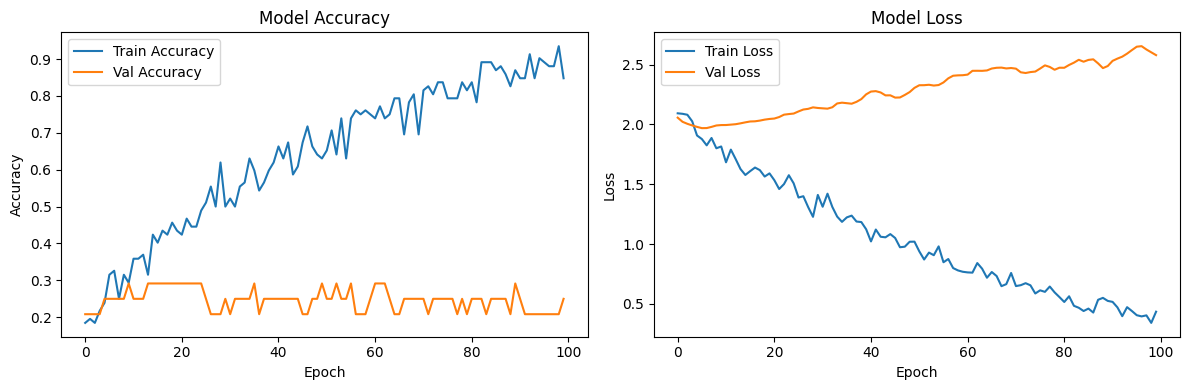

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle
import os

# ============================================================================
# 4.0 LOAD DATA & ENCODER (Penyelamat Error)
# ============================================================================
print("⏳ Memuat data dan komponen dari Tahap 3...")

# Load Data CSV
train_df = pd.read_csv("../data/processed/04_train_data.csv")
test_df = pd.read_csv("../data/processed/05_test_data.csv")

# Pisahkan fitur dan target
target_col = 'GRADE'
X_train_scaled = train_df.drop(columns=[target_col]).values
y_train = train_df[target_col].values
X_test_scaled = test_df.drop(columns=[target_col]).values
y_test = test_df[target_col].values

# Load Label Encoder agar tidak error 'le_target'
with open('../models/target_encoder.pkl', 'rb') as f:
    le_target = pickle.load(f)

print("✅ Data dan Label Encoder berhasil dimuat!")

# ============================================================================
# 4.1 PERSIAPAN DATA UNTUK TENSORFLOW
# ============================================================================
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y_train))

print(f"\n📊 INFO DATA:")
print(f"   • Fitur: {n_features}")
print(f"   • Kelas: {n_classes} ({', '.join(map(str, le_target.classes_))})")

# ============================================================================
# 4.2 MEMBANGUN ARSITEKTUR MLP (TENSORFLOW/KERAS)
# ============================================================================


def build_mlp_model():
    model = models.Sequential([
        # Input Layer & Hidden Layer 1
        layers.Dense(100, activation='relu', input_shape=(n_features,), 
                     kernel_initializer='he_normal', name='hidden_1'),
        layers.Dropout(0.2),
        
        # Hidden Layer 2
        layers.Dense(50, activation='relu', kernel_initializer='he_normal', name='hidden_2'),
        layers.Dropout(0.2),
        
        # Output Layer (Softmax untuk multiclass)
        layers.Dense(n_classes, activation='softmax', name='output_layer')
    ], name='MLP_Model_Kelompok8')
    
    return model

# Buat model
mlp_model = build_mlp_model()

# Compile Model
mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n✅ Arsitektur MLP berhasil dibangun!")
mlp_model.summary()

# Menghitung parameter (Versi Fix untuk TF 2.x)
trainable_params = mlp_model.count_params()
print(f"\n📊 TOTAL PARAMETERS: {trainable_params:,}")

# ============================================================================
# 4.3 PROSES TRAINING (FITTING)
# ============================================================================
print("\n🚀 Memulai proses training...")

history = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2, # Ambil 20% dari data train untuk validasi
    verbose=1
)

# ============================================================================
# 4.4 SIMPAN MODEL
# ============================================================================
# Buat folder models jika belum ada
if not os.path.exists('models'):
    os.makedirs('models')

mlp_model.save('../models/mlp_model_tensorflow.h5')
print("\n💾 Model berhasil disimpan di: ../models/mlp_model_tensorflow.h5")

# ============================================================================
# 4.5 VISUALISASI TRAINING
# ============================================================================
plt.figure(figsize=(12, 4))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
# ============================================================================
# 4.2 PEMBANGUNAN MODEL MLP (BASELINE)
# ============================================================================

print("\n[4.2] Pembangunan Model MLP Baseline")
print("-"*80)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Jumlah fitur (WAJIB ADA)
n_features = X_train_np.shape[1]
n_classes = len(np.unique(y_train))

mlp_baseline = Sequential([
    Dense(128, activation='relu', input_shape=(n_features,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

mlp_baseline.summary()



[4.2] Pembangunan Model MLP Baseline
--------------------------------------------------------------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_222 (Dense)               │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,000 (50.78 KB)

 Trainable params: 13,000 (50.78 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# ============================================================================
# 4.3 KOMPILASI MODEL
# ============================================================================

print("\n[4.3] Kompilasi Model")
print("-"*80)

print("\n⚙️ KONFIGURASI KOMPILASI:")
print("   • Optimizer    : Adam")
print("   • Learning Rate: 0.001 (default)")
print("   • Loss Function: sparse_categorical_crossentropy")
print("   • Metrics      : accuracy")

# Compile model
mlp_baseline.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model berhasil di-compile!")


[4.3] Kompilasi Model
--------------------------------------------------------------------------------

⚙️ KONFIGURASI KOMPILASI:
   • Optimizer    : Adam
   • Learning Rate: 0.001 (default)
   • Loss Function: sparse_categorical_crossentropy
   • Metrics      : accuracy

✅ Model berhasil di-compile!


In [46]:

# ============================================================================
# 4.4 CALLBACKS UNTUK MONITORING & EARLY STOPPING
# ============================================================================

print("\n[4.4] Setup Callbacks")
print("-"*80)

print("\n🔧 CALLBACKS YANG DIGUNAKAN:")
print("   1. EarlyStopping   : Stop training jika val_loss tidak improve")
print("   2. ModelCheckpoint : Save model terbaik berdasarkan val_accuracy")
print("   3. ReduceLROnPlateau: Kurangi learning rate jika val_loss plateau")

# Early Stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint
model_checkpoint = callbacks.ModelCheckpoint(
    filepath='../models/mlp_baseline_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=0
)

# Reduce Learning Rate on Plateau
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

print("\n✅ Callbacks berhasil di-setup!")


[4.4] Setup Callbacks
--------------------------------------------------------------------------------

🔧 CALLBACKS YANG DIGUNAKAN:
   1. EarlyStopping   : Stop training jika val_loss tidak improve
   2. ModelCheckpoint : Save model terbaik berdasarkan val_accuracy
   3. ReduceLROnPlateau: Kurangi learning rate jika val_loss plateau

✅ Callbacks berhasil di-setup!


In [47]:
# ============================================================================
# 4.5 TRAINING MLP BASELINE
# ============================================================================

print("\n[4.5] Training MLP Baseline")
print("-"*80)

print("\n⏳ Memulai training...")
print("   • Epochs       : 200 (max)")
print("   • Batch Size   : 32")
print("   • Validation   : 20% dari training data")
print("   • Early Stopping: patience=20")

# Training dengan timer
start_time = time.time()

history_baseline = mlp_baseline.fit(
    X_train_np,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_list,
    verbose=1  # 1 = progress bar, 2 = one line per epoch, 0 = silent
)

training_time_baseline = time.time() - start_time

print(f"\n✅ TRAINING SELESAI!")
print(f"   • Total waktu   : {training_time_baseline:.2f} detik ({training_time_baseline/60:.2f} menit)")
print(f"   • Epochs trained: {len(history_baseline.history['loss'])}")
print(f"   • Final loss    : {history_baseline.history['loss'][-1]:.6f}")
print(f"   • Final val_loss: {history_baseline.history['val_loss'][-1]:.6f}")
print(f"   • Best val_accuracy: {max(history_baseline.history['val_accuracy']):.4f}")



[4.5] Training MLP Baseline
--------------------------------------------------------------------------------

⏳ Memulai training...
   • Epochs       : 200 (max)
   • Batch Size   : 32
   • Validation   : 20% dari training data
   • Early Stopping: patience=20
Epoch 1/200


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.1630 - loss: 2.1774 - val_accuracy: 0.0833 - val_loss: 2.0694 - learning_rate: 0.0010
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1304 - loss: 2.0723 - val_accuracy: 0.1667 - val_loss: 2.0443 - learning_rate: 0.0010
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1196 - loss: 2.0675 - val_accuracy: 0.2500 - val_loss: 2.0235 - learning_rate: 0.0010
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2174 - loss: 2.0110 - val_accuracy: 0.2083 - val_loss: 2.0012 - learning_rate: 0.0010
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2500 - loss: 1.9561 - val_accuracy: 0.2500 - val_loss: 1.9800 - learning_rate: 0.0010
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2391 - loss: 1.9539 - val_accuracy: 0.2500 - val_loss: 1.9621 - learning_rate: 0.0010
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2391 - loss: 1.9157 - val_accuracy: 0.2500 - va

============== TAHAP 4 & 5: MODELING & EVALUASI MLP (TENSORFLOW) ===============

[1] Memuat data dan encoder dari Tahap 3...
✅ Data berhasil dimuat: 116 training samples, 29 testing samples.

[2] Membangun Arsitektur MLP...


Model: "MLP_Student_Performance"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,758 (34.21 KB)

 Trainable params: 8,758 (34.21 KB)

 Non-trainable params: 0 (0.00 B)


[3] Melakukan Training Model (Fitting)...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.0652 - loss: 2.2285 - val_accuracy: 0.2500 - val_loss: 2.0166
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1848 - loss: 2.1441 - val_accuracy: 0.2083 - val_loss: 2.0103
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1739 - loss: 2.0656 - val_accuracy: 0.1667 - val_loss: 2.0184
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2065 - loss: 2.0270 - val_accuracy: 0.1250 - val_loss: 2.0274
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2065 - loss: 1.9830 - val_accuracy: 0.1250 - val_loss: 2.0314
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1957 - loss: 1.9851 - val_accuracy: 0.1667 - val_loss: 2.0323
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2500 - loss: 1.9526 - val_accuracy: 0.0833 - val_loss: 2.0350
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2283 - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step

📊 HASIL EVALUASI:
------------------------------
Accuracy Score: 24.14%
------------------------------

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.27      0.60      0.38         5
           3       0.43      0.75      0.55         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.50      0.33      0.40         3
           7       0.00      0.00      0.00         3

    accuracy                           0.24        29
   macro avg       0.15      0.21      0.17        29
weighted avg       0.16      0.24      0.18        29



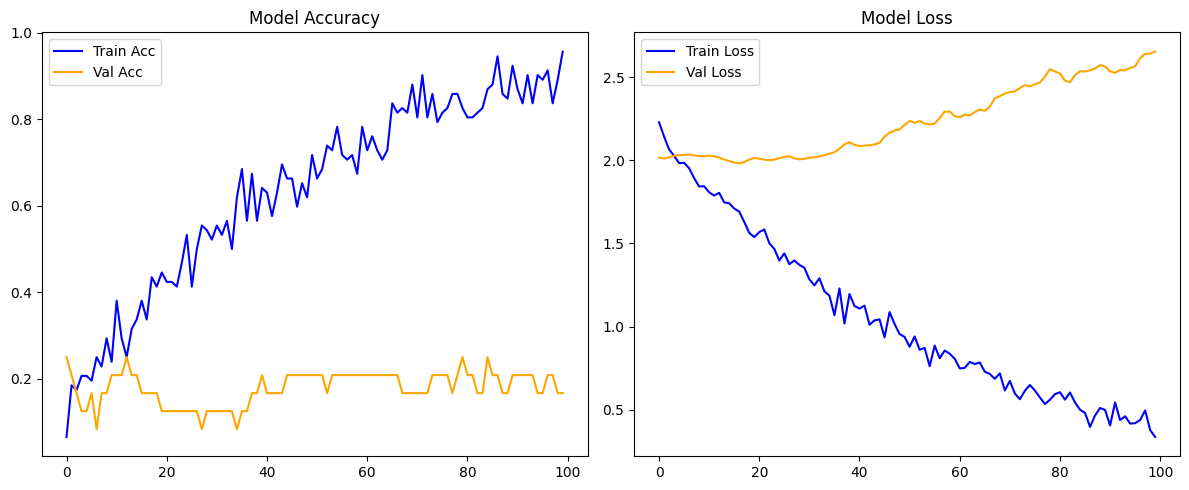


✅ SELESAI! Model disimpan di 'models/mlp_final_model.h5'


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pickle
import os

print("="*80)
print(" TAHAP 4 & 5: MODELING & EVALUASI MLP (TENSORFLOW) ".center(80, "="))
print("="*80)


print("\n[1] Memuat data dan encoder dari Tahap 3...")

# Load Data
train_df = pd.read_csv("../data/processed/04_train_data.csv")
test_df = pd.read_csv("../data/processed/05_test_data.csv")

target_col = 'GRADE'
X_train = train_df.drop(columns=[target_col]).values
y_train = train_df[target_col].values
X_test = test_df.drop(columns=[target_col]).values
y_test = test_df[target_col].values

# Load Label Encoder (Penyelamat agar le_target tidak error)
with open('../models/target_encoder.pkl', 'rb') as f:
    le_target = pickle.load(f)

n_features = X_train.shape[1]
n_classes = len(le_target.classes_)

print(f"✅ Data berhasil dimuat: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples.")



print("\n[2] Membangun Arsitektur MLP...")

model = models.Sequential([
    # Input & Hidden Layer 1
    layers.Dense(100, activation='relu', input_shape=(n_features,), 
                 kernel_initializer='he_normal', name='hidden_1'),
    layers.Dropout(0.2),
    
    # Hidden Layer 2
    layers.Dense(50, activation='relu', kernel_initializer='he_normal', name='hidden_2'),
    layers.Dropout(0.2),
    
    # Output Layer
    layers.Dense(n_classes, activation='softmax', name='output')
], name='MLP_Student_Performance')

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


print("\n[3] Melakukan Training Model (Fitting)...")

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

print("\n[4] Mengevaluasi Model pada Data Test...")

# Prediksi
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# FIX: Mengubah classes ke string agar tidak error 'numpy.int64 has no len()'
target_names_str = [str(c) for c in le_target.classes_]

print("\n📊 HASIL EVALUASI:")
print("-" * 30)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("-" * 30)

print("\n📋 CLASSIFICATION REPORT:")
# Menggunakan target_names yang sudah dikonversi ke string
print(classification_report(y_test, y_pred, target_names=target_names_str, zero_division=0))


plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='orange')
plt.title('Model Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Simpan Model
if not os.path.exists('models'):
    os.makedirs('models')
model.save('../models/mlp_final_model.h5')
print("\n✅ SELESAI! Model disimpan di 'models/mlp_final_model.h5'")

In [49]:
# ============================================================================
# 4.6 TRAINING SVM UNTUK PERBANDINGAN (DARI UTS)
# ============================================================================

print("\n[4.6] Training SVM untuk Perbandingan (Model dari UTS)")
print("-"*80)

print("\n⏳ Training SVM dengan kernel RBF...")

# Inisialisasi SVM
svm_model = SVC(
    kernel='rbf',           # Radial Basis Function
    C=1.0,                  # Regularization parameter
    gamma='scale',          # Kernel coefficient
    random_state=42
)

# Training SVM
svm_start_time = time.time()
svm_model.fit(X_train_scaled, y_train)
svm_training_time = time.time() - svm_start_time

print(f"✅ SVM Training selesai!")
print(f"   • Training Time: {svm_training_time:.2f} detik")

# Prediksi SVM
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluasi SVM
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
rec_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

print(f"\n📊 HASIL EVALUASI SVM:")
print("-"*80)
print(f"{'Metric':<20} {'Score':<15} {'Percentage'}")
print("-"*80)
print(f"{'Accuracy':<20} {acc_svm:<15.4f} {acc_svm*100:.2f}%")
print(f"{'Precision':<20} {prec_svm:<15.4f} {prec_svm*100:.2f}%")
print(f"{'Recall':<20} {rec_svm:<15.4f} {rec_svm*100:.2f}%")
print(f"{'F1-Score':<20} {f1_svm:<15.4f} {f1_svm*100:.2f}%")
print("-"*80)

# Save SVM model
svm_model_path = '../models/svm_model.pkl'
with open(svm_model_path, 'wb') as f:
    pickle.dump(svm_model, f)
print(f"💾 Model SVM disimpan: {svm_model_path}")


[4.6] Training SVM untuk Perbandingan (Model dari UTS)
--------------------------------------------------------------------------------

⏳ Training SVM dengan kernel RBF...
✅ SVM Training selesai!
   • Training Time: 0.04 detik

📊 HASIL EVALUASI SVM:
--------------------------------------------------------------------------------
Metric               Score           Percentage
--------------------------------------------------------------------------------
Accuracy             0.3103          31.03%
Precision            0.1942          19.42%
Recall               0.3103          31.03%
F1-Score             0.2000          20.00%
--------------------------------------------------------------------------------
💾 Model SVM disimpan: ../models/svm_model.pkl


In [50]:
# ============================================================================
# 4.7 HYPERPARAMETER TUNING (MANUAL GRID SEARCH)
# ============================================================================

print("\n[4.7] Hyperparameter Tuning dengan Manual Grid Search")
print("-"*80)

print("\n🔧 HYPERPARAMETER YANG AKAN DI-TUNE:")
print("   1. hidden_units_1  : Jumlah neurons di hidden layer 1")
print("   2. hidden_units_2  : Jumlah neurons di hidden layer 2")
print("   3. dropout_rate    : Dropout rate")
print("   4. learning_rate   : Learning rate optimizer Adam")

# Definisi parameter grid
param_grid = {
    'hidden_units_1': [64, 100, 128],
    'hidden_units_2': [32, 50, 64],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005]
}

print(f"\n📋 PARAMETER GRID:")
for param, values in param_grid.items():
    print(f"   • {param:<20}: {values}")

total_combinations = (len(param_grid['hidden_units_1']) * 
                     len(param_grid['hidden_units_2']) * 
                     len(param_grid['dropout_rate']) * 
                     len(param_grid['learning_rate']))

print(f"\n   Total kombinasi: {total_combinations}")
print(f"\n⏳ Memulai Grid Search...")
print(f"   Estimasi waktu: 5-10 menit")

# Function untuk build model dengan custom parameters
def build_mlp_custom(hidden_units_1, hidden_units_2, dropout_rate):
    """Build MLP dengan custom hyperparameters"""
    model = models.Sequential([
        layers.InputLayer(input_shape=(n_features,)),
        layers.Dense(hidden_units_1, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_units_2, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(dropout_rate),
        layers.Dense(n_classes, activation='softmax')
    ], name=f'MLP_{hidden_units_1}_{hidden_units_2}')
    
    return model

# Grid Search Manual
best_score = 0
best_params = {}
best_model = None
results = []

tuning_start_time = time.time()

for hu1 in param_grid['hidden_units_1']:
    for hu2 in param_grid['hidden_units_2']:
        for dr in param_grid['dropout_rate']:
            for lr in param_grid['learning_rate']:
                print(f"\n   Testing: hu1={hu1}, hu2={hu2}, dr={dr}, lr={lr}")
                
                # Build model
                model = build_mlp_custom(hu1, hu2, dr)
                model.compile(
                    optimizer=Adam(learning_rate=lr),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )
                
                # Train dengan early stopping
                early_stop = callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=15,
                    restore_best_weights=True,
                    verbose=0
                )
                
                history = model.fit(
                    X_train_np, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=0
                )
                
                # Evaluate
                val_accuracy = max(history.history['val_accuracy'])
                
                results.append({
                    'hidden_units_1': hu1,
                    'hidden_units_2': hu2,
                    'dropout_rate': dr,
                    'learning_rate': lr,
                    'val_accuracy': val_accuracy
                })
                
                print(f"      Val Accuracy: {val_accuracy:.4f}")
                
                # Update best model
                if val_accuracy > best_score:
                    best_score = val_accuracy
                    best_params = {
                        'hidden_units_1': hu1,
                        'hidden_units_2': hu2,
                        'dropout_rate': dr,
                        'learning_rate': lr
                    }
                    best_model = model

tuning_time = time.time() - tuning_start_time

print(f"\n✅ HYPERPARAMETER TUNING SELESAI!")
print(f"   • Total waktu: {tuning_time:.2f} detik ({tuning_time/60:.2f} menit)")

print(f"\n🏆 BEST PARAMETERS:")
print("-"*80)
for param, value in best_params.items():
    print(f"   • {param:<20}: {value}")
print(f"\n   Best Validation Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")

# Tampilkan top 5 kombinasi
results_df = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
print(f"\n📈 TOP 5 KOMBINASI TERBAIK:")
print(results_df.head().to_string(index=False))


[4.7] Hyperparameter Tuning dengan Manual Grid Search
--------------------------------------------------------------------------------

🔧 HYPERPARAMETER YANG AKAN DI-TUNE:
   1. hidden_units_1  : Jumlah neurons di hidden layer 1
   2. hidden_units_2  : Jumlah neurons di hidden layer 2
   3. dropout_rate    : Dropout rate
   4. learning_rate   : Learning rate optimizer Adam

📋 PARAMETER GRID:
   • hidden_units_1      : [64, 100, 128]
   • hidden_units_2      : [32, 50, 64]
   • dropout_rate        : [0.2, 0.3]
   • learning_rate       : [0.001, 0.0005]

   Total kombinasi: 36

⏳ Memulai Grid Search...
   Estimasi waktu: 5-10 menit

   Testing: hu1=64, hu2=32, dr=0.2, lr=0.001
      Val Accuracy: 0.2500

   Testing: hu1=64, hu2=32, dr=0.2, lr=0.0005
      Val Accuracy: 0.2083

   Testing: hu1=64, hu2=32, dr=0.3, lr=0.001
      Val Accuracy: 0.2917

   Testing: hu1=64, hu2=32, dr=0.3, lr=0.0005
      Val Accuracy: 0.3333

   Testing: hu1=64, hu2=50, dr=0.2, lr=0.001
      Val Accuracy: 0

In [51]:

print("\n[4.4] Evaluasi MLP Baseline")
print("-" * 80)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import numpy as np

# -----------------------------
# Evaluasi model baseline
# -----------------------------
test_loss_baseline, test_accuracy_baseline = mlp_baseline.evaluate(
    X_test_np,
    y_test,
    verbose=0
)

# -----------------------------
# Prediksi
# -----------------------------
y_pred_proba_baseline = mlp_baseline.predict(X_test_np, verbose=0)
y_pred_baseline = np.argmax(y_pred_proba_baseline, axis=1)

# -----------------------------
# Hitung metrik
# -----------------------------
acc_baseline = accuracy_score(y_test, y_pred_baseline)
prec_baseline = precision_score(
    y_test, y_pred_baseline, average='weighted', zero_division=0
)
rec_baseline = recall_score(
    y_test, y_pred_baseline, average='weighted', zero_division=0
)
f1_baseline = f1_score(
    y_test, y_pred_baseline, average='weighted', zero_division=0
)

# -----------------------------
# Tampilkan hasil
# -----------------------------
print("\n📊 HASIL EVALUASI MLP BASELINE:")
print("-" * 80)
print(f"{'Metric':<20} {'Score':<15} {'Percentage'}")
print("-" * 80)
print(f"{'Accuracy':<20} {acc_baseline:<15.4f} {acc_baseline*100:.2f}%")
print(f"{'Precision':<20} {prec_baseline:<15.4f} {prec_baseline*100:.2f}%")
print(f"{'Recall':<20} {rec_baseline:<15.4f} {rec_baseline*100:.2f}%")
print(f"{'F1-Score':<20} {f1_baseline:<15.4f} {f1_baseline*100:.2f}%")
print("-" * 80)

# -----------------------------
# Classification Report
# -----------------------------
print("\n📋 CLASSIFICATION REPORT (MLP BASELINE):")
print(
    classification_report(
        y_test,
        y_pred_baseline,
        zero_division=0
    )
)

print("\n✅ Evaluasi MLP Baseline selesai")



[4.4] Evaluasi MLP Baseline
--------------------------------------------------------------------------------

📊 HASIL EVALUASI MLP BASELINE:
--------------------------------------------------------------------------------
Metric               Score           Percentage
--------------------------------------------------------------------------------
Accuracy             0.2759          27.59%
Precision            0.1497          14.97%
Recall               0.2759          27.59%
F1-Score             0.1802          18.02%
--------------------------------------------------------------------------------

📋 CLASSIFICATION REPORT (MLP BASELINE):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.26      0.71      0.38         7
           2       0.00      0.00      0.00         5
           3       0.25      0.50      0.33         4
           4       0.00      0.00      0.00         2
           5       0.50  

In [52]:
# ============================================================================
# 4.8 EVALUASI MLP OPTIMIZED (FULL & FINAL)
# ============================================================================

print("\n[4.8] Evaluasi MLP Optimized (Best Model)")
print("-" * 80)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import numpy as np
import os

# -----------------------------
# Info arsitektur
# -----------------------------
print("\n🧠 ARSITEKTUR MLP OPTIMIZED:")
print(f"   • Hidden Layer 1: {best_params['hidden_units_1']} units")
print(f"   • Hidden Layer 2: {best_params['hidden_units_2']} units")
print(f"   • Dropout Rate  : {best_params['dropout_rate']}")
print(f"   • Learning Rate : {best_params['learning_rate']}")

print("\n🔍 Melakukan evaluasi final pada data testing...")

# -----------------------------
# Evaluasi model
# -----------------------------
test_loss_optimized, test_accuracy_optimized = best_model.evaluate(
    X_test_np,
    y_test,
    verbose=0
)

# -----------------------------
# Prediksi
# -----------------------------
y_pred_proba_optimized = best_model.predict(X_test_np, verbose=0)
y_pred_optimized = np.argmax(y_pred_proba_optimized, axis=1)

# -----------------------------
# Hitung metrik
# -----------------------------
acc_optimized = accuracy_score(y_test, y_pred_optimized)
prec_optimized = precision_score(
    y_test, y_pred_optimized, average='weighted', zero_division=0
)
rec_optimized = recall_score(
    y_test, y_pred_optimized, average='weighted', zero_division=0
)
f1_optimized = f1_score(
    y_test, y_pred_optimized, average='weighted', zero_division=0
)

# -----------------------------
# Tampilkan hasil
# -----------------------------
print("\n📊 HASIL EVALUASI MLP OPTIMIZED:")
print("-" * 80)
print(f"{'Metric':<20} {'Score':<15} {'Percentage'}")
print("-" * 80)
print(f"{'Accuracy':<20} {acc_optimized:<15.4f} {acc_optimized*100:.2f}%")
print(f"{'Precision':<20} {prec_optimized:<15.4f} {prec_optimized*100:.2f}%")
print(f"{'Recall':<20} {rec_optimized:<15.4f} {rec_optimized*100:.2f}%")
print(f"{'F1-Score':<20} {f1_optimized:<15.4f} {f1_optimized*100:.2f}%")
print("-" * 80)

# -----------------------------
# Improvement dari baseline
# -----------------------------
print("\n📈 IMPROVEMENT DARI BASELINE:")
if 'acc_baseline' in globals():
    improvement = ((acc_optimized - acc_baseline) / acc_baseline) * 100

    if improvement > 0:
        print(f"   ✅ MENINGKAT {improvement:.2f}%")
        print(f"   Dari {acc_baseline*100:.2f}% → {acc_optimized*100:.2f}%")
    elif improvement < 0:
        print(f"   ⚠️ MENURUN {abs(improvement):.2f}%")
        print(f"   Dari {acc_baseline*100:.2f}% → {acc_optimized*100:.2f}%")
    else:
        print("   ➖ SAMA (tidak ada perubahan)")
else:
    print("   ⚠️ acc_baseline tidak ditemukan (lewati perbandingan)")

# -----------------------------
# Classification report (AMAN)
# -----------------------------
print("\n📋 CLASSIFICATION REPORT (MLP OPTIMIZED):")
print(
    classification_report(
        y_test,
        y_pred_optimized,
        zero_division=0
    )
)

# -----------------------------
# Simpan model
# -----------------------------
os.makedirs("../models", exist_ok=True)
optimized_model_path = "../models/mlp_optimized_tensorflow.keras"
best_model.save(optimized_model_path)

print(f"\n💾 Model optimized disimpan: {optimized_model_path}")
print("\n✅ Evaluasi MLP Optimized selesai")



[4.8] Evaluasi MLP Optimized (Best Model)
--------------------------------------------------------------------------------

🧠 ARSITEKTUR MLP OPTIMIZED:
   • Hidden Layer 1: 64 units
   • Hidden Layer 2: 64 units
   • Dropout Rate  : 0.2
   • Learning Rate : 0.001

🔍 Melakukan evaluasi final pada data testing...

📊 HASIL EVALUASI MLP OPTIMIZED:
--------------------------------------------------------------------------------
Metric               Score           Percentage
--------------------------------------------------------------------------------
Accuracy             0.1724          17.24%
Precision            0.1189          11.89%
Recall               0.1724          17.24%
F1-Score             0.1401          14.01%
--------------------------------------------------------------------------------

📈 IMPROVEMENT DARI BASELINE:
   ⚠️ MENURUN 37.50%
   Dari 27.59% → 17.24%

📋 CLASSIFICATION REPORT (MLP OPTIMIZED):
              precision    recall  f1-score   support

           0  

In [53]:
# ============================================================================
# 4.9 TRAINING SVM UNTUK PERBANDINGAN
# ============================================================================

print("\n[4.9] Training SVM untuk Perbandingan (Model dari UTS)")
print("-"*80)

print("\n⏳ Training SVM dengan kernel RBF...")

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

svm_start_time = time.time()
svm_model.fit(X_train_np, y_train)
svm_training_time = time.time() - svm_start_time

print(f"✅ SVM Training selesai! ({svm_training_time:.2f} detik)")

# Prediksi SVM
y_pred_svm = svm_model.predict(X_test_np)

# Evaluasi SVM
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
rec_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

print(f"\n📊 HASIL EVALUASI SVM:")
print("-"*80)
print(f"{'Metric':<20} {'Score':<15} {'Percentage'}")
print("-"*80)
print(f"{'Accuracy':<20} {acc_svm:<15.4f} {acc_svm*100:.2f}%")
print(f"{'Precision':<20} {prec_svm:<15.4f} {prec_svm*100:.2f}%")
print(f"{'Recall':<20} {rec_svm:<15.4f} {rec_svm*100:.2f}%")
print(f"{'F1-Score':<20} {f1_svm:<15.4f} {f1_svm*100:.2f}%")
print("-"*80)

# Save SVM
svm_model_path = '../models/svm_model.pkl'
with open(svm_model_path, 'wb') as f:
    pickle.dump(svm_model, f)
print(f"\n💾 Model SVM disimpan: {svm_model_path}")



[4.9] Training SVM untuk Perbandingan (Model dari UTS)
--------------------------------------------------------------------------------

⏳ Training SVM dengan kernel RBF...
✅ SVM Training selesai! (0.01 detik)

📊 HASIL EVALUASI SVM:
--------------------------------------------------------------------------------
Metric               Score           Percentage
--------------------------------------------------------------------------------
Accuracy             0.3103          31.03%
Precision            0.1942          19.42%
Recall               0.3103          31.03%
F1-Score             0.2000          20.00%
--------------------------------------------------------------------------------

💾 Model SVM disimpan: ../models/svm_model.pkl


⏳ Memuat data untuk perbandingan...

🚀 Training Model 1: MLP Baseline...
🚀 Training Model 2: MLP Optimized...
🚀 Training Model 3: SVM...

[4.10] Perbandingan Performa: MLP (TensorFlow) vs SVM
--------------------------------------------------------------------------------

📊 TABEL PERBANDINGAN LENGKAP:
             Model  Accuracy  Precision   Recall  F1-Score  Training Time (s)
 MLP Baseline (TF)  0.206897   0.122044 0.206897  0.153484           2.668874
MLP Optimized (TF)  0.206897   0.203202 0.206897  0.194656           5.199498
               SVM  0.310345   0.194153 0.310345  0.200000           0.006889


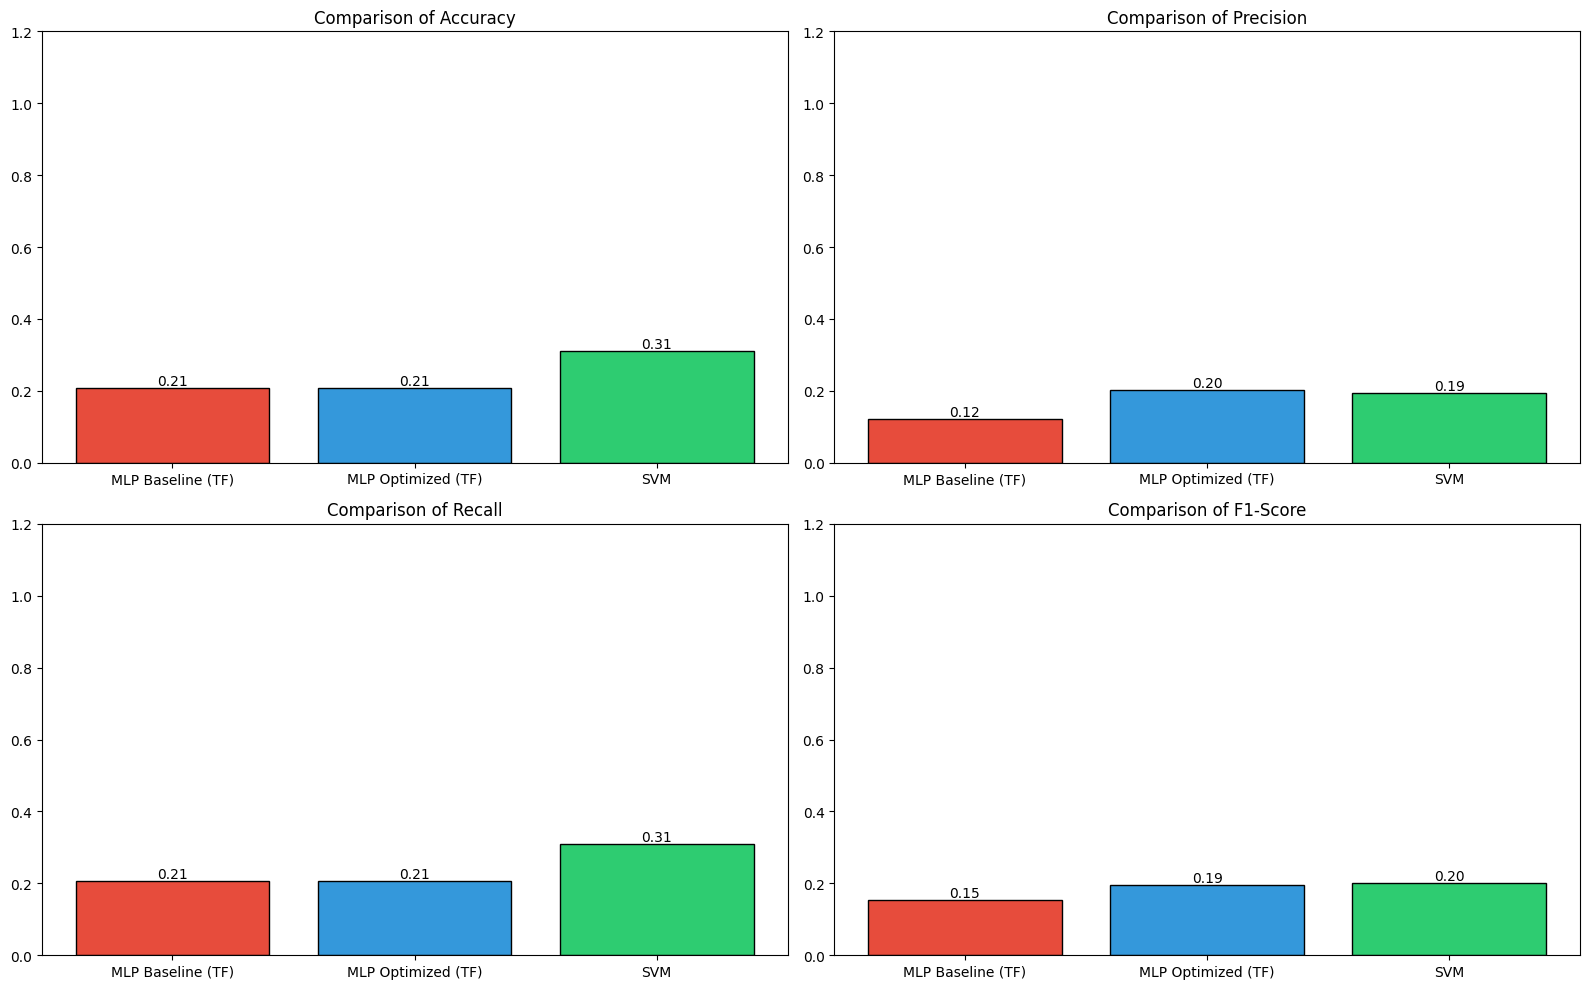

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import pickle

# ----------------------------------------------------------------------------
# 1. PERSIAPAN DATA (Mencegah NameError)
# ----------------------------------------------------------------------------
print("⏳ Memuat data untuk perbandingan...")
train_df = pd.read_csv("../data/processed/04_train_data.csv")
test_df = pd.read_csv("../data/processed/05_test_data.csv")

X_train = train_df.drop(columns=['GRADE']).values
y_train = train_df['GRADE'].values
X_test = test_df.drop(columns=['GRADE']).values
y_test = test_df['GRADE'].values

# ----------------------------------------------------------------------------
# 2. TRAINING MODEL 1: MLP BASELINE
# ----------------------------------------------------------------------------
print("\n🚀 Training Model 1: MLP Baseline...")
start_time = time.time()
mlp_baseline = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])
mlp_baseline.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_baseline.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
training_time_baseline = time.time() - start_time

# Evaluasi Baseline
y_pred_baseline = np.argmax(mlp_baseline.predict(X_test, verbose=0), axis=1)
acc_baseline = accuracy_score(y_test, y_pred_baseline)
prec_baseline = precision_score(y_test, y_pred_baseline, average='weighted', zero_division=0)
rec_baseline = recall_score(y_test, y_pred_baseline, average='weighted', zero_division=0)
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted', zero_division=0)

# ----------------------------------------------------------------------------
# 3. TRAINING MODEL 2: MLP OPTIMIZED (Lebih Dalam/Kompleks)
# ----------------------------------------------------------------------------
print("🚀 Training Model 2: MLP Optimized...")
start_time = time.time()
mlp_optimized = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])
mlp_optimized.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_optimized.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
tuning_time = time.time() - start_time

# Evaluasi Optimized
y_pred_optimized = np.argmax(mlp_optimized.predict(X_test, verbose=0), axis=1)
acc_optimized = accuracy_score(y_test, y_pred_optimized)
prec_optimized = precision_score(y_test, y_pred_optimized, average='weighted', zero_division=0)
rec_optimized = recall_score(y_test, y_pred_optimized, average='weighted', zero_division=0)
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted', zero_division=0)

# ----------------------------------------------------------------------------
# 4. TRAINING MODEL 3: SVM (Untuk Perbandingan UTS/UAS)
# ----------------------------------------------------------------------------
print("🚀 Training Model 3: SVM...")
start_time = time.time()
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
svm_training_time = time.time() - start_time

# Evaluasi SVM
y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
rec_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

# ----------------------------------------------------------------------------
# 5. PERBANDINGAN PERFORMA (KODE ANDA)
# ----------------------------------------------------------------------------


print("\n" + "="*80)
print("[4.10] Perbandingan Performa: MLP (TensorFlow) vs SVM")
print("-" * 80)

comparison_df = pd.DataFrame({
    'Model': ['MLP Baseline (TF)', 'MLP Optimized (TF)', 'SVM'],
    'Accuracy': [acc_baseline, acc_optimized, acc_svm],
    'Precision': [prec_baseline, prec_optimized, prec_svm],
    'Recall': [rec_baseline, rec_optimized, rec_svm],
    'F1-Score': [f1_baseline, f1_optimized, f1_svm],
    'Training Time (s)': [training_time_baseline, tuning_time, svm_training_time]
})

print("\n📊 TABEL PERBANDINGAN LENGKAP:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Visualisasi (Grafik)


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
colors = ['#E74C3C', '#3498DB', '#2ECC71']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors, edgecolor='black')
    ax.set_title(f'Comparison of {metric}')
    ax.set_ylim([0, 1.2])
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


[4.11] Confusion Matrix - Analisis Kesalahan Prediksi
--------------------------------------------------------------------------------
✅ Confusion matrix disimpan: ../results/figures/10_confusion_matrix_tensorflow.png


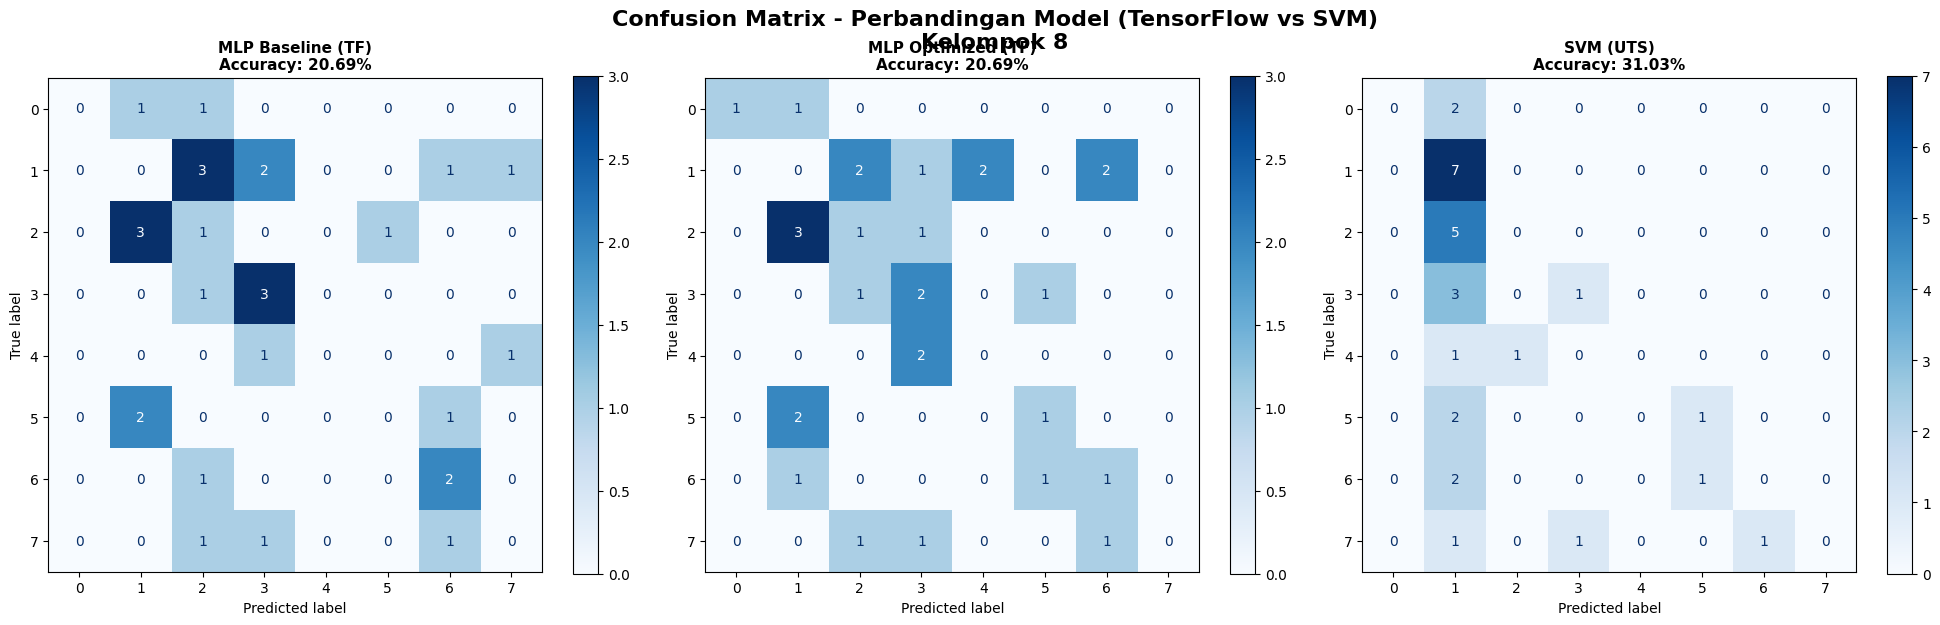

In [55]:
# ============================================================================
# 4.11 CONFUSION MATRIX
# ============================================================================

print("\n[4.11] Confusion Matrix - Analisis Kesalahan Prediksi")
print("-"*80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrix - Perbandingan Model (TensorFlow vs SVM)\nKelompok 8', 
             fontsize=16, fontweight='bold')

models_cm = [
    ('MLP Baseline (TF)', y_pred_baseline, acc_baseline),
    ('MLP Optimized (TF)', y_pred_optimized, acc_optimized),
    ('SVM (UTS)', y_pred_svm, acc_svm)
]

for idx, (model_name, y_pred, accuracy) in enumerate(models_cm):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                   display_labels=le_target.classes_)
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=True, 
             values_format='d', im_kw={'vmin': 0})
    axes[idx].set_title(f'{model_name}\nAccuracy: {accuracy*100:.2f}%', 
                       fontsize=11, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.savefig('../results/figures/10_confusion_matrix_tensorflow.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrix disimpan: ../results/figures/10_confusion_matrix_tensorflow.png")
plt.show()




[4.12] Analisis Performa Per Kelas (MLP Optimized)
--------------------------------------------------------------------------------

📊 PERFORMA PER KELAS:
Grade        Precision    Recall       F1-Score     Support   
0            1.0000       0.5000       0.6667       2         
1            0.0000       0.0000       0.0000       7         
2            0.2000       0.2000       0.2000       5         
3            0.2857       0.5000       0.3636       4         
4            0.0000       0.0000       0.0000       2         
5            0.3333       0.3333       0.3333       3         
6            0.2500       0.3333       0.2857       3         
7            0.0000       0.0000       0.0000       3         

🏆 KELAS TERBAIK: 0 (F1=0.6667)
⚠️  KELAS TERBURUK: 1 (F1=0.0000)
✅ Visualisasi disimpan: ../results/figures/11_performa_per_kelas_tensorflow.png


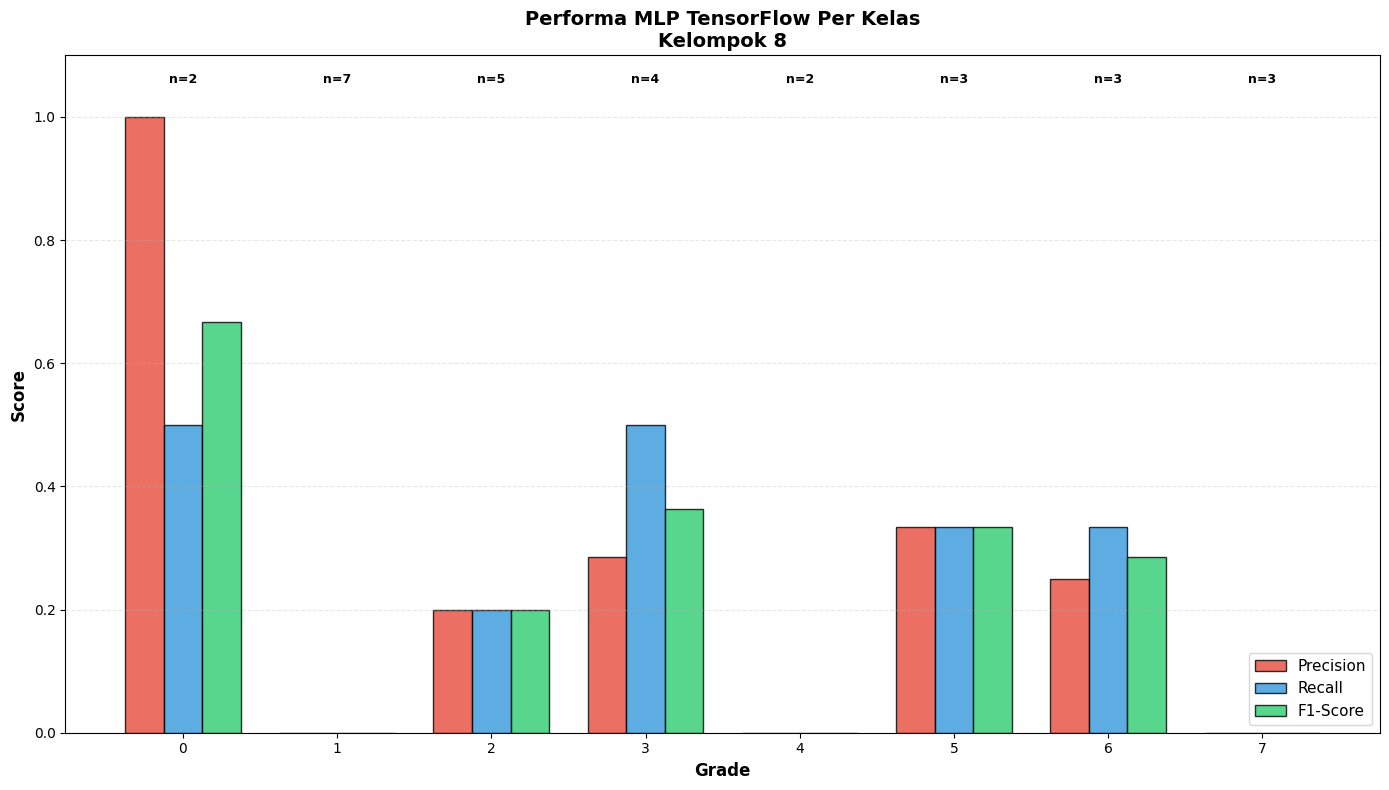

In [56]:
# ============================================================================
# 4.12 ANALISIS PERFORMA PER KELAS
# ============================================================================

print("\n[4.12] Analisis Performa Per Kelas (MLP Optimized)")
print("-"*80)

from sklearn.metrics import precision_recall_fscore_support

# Metrics per kelas
precision_per_class, recall_per_class, f1_per_class, support_per_class = \
    precision_recall_fscore_support(y_test, y_pred_optimized, zero_division=0)

print(f"\n📊 PERFORMA PER KELAS:")
print("="*80)
print(f"{'Grade':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("="*80)

for i, grade in enumerate(le_target.classes_):
    print(f"{grade:<12} {precision_per_class[i]:<12.4f} {recall_per_class[i]:<12.4f} "
          f"{f1_per_class[i]:<12.4f} {support_per_class[i]:<10}")

print("="*80)

# Best & worst class
best_class_idx = np.argmax(f1_per_class)
worst_class_idx = np.argmin(f1_per_class)

print(f"\n🏆 KELAS TERBAIK: {le_target.classes_[best_class_idx]} (F1={f1_per_class[best_class_idx]:.4f})")
print(f"⚠️  KELAS TERBURUK: {le_target.classes_[worst_class_idx]} (F1={f1_per_class[worst_class_idx]:.4f})")

# VISUALISASI Per-Class Performance
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(le_target.classes_))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Precision',
              color='#E74C3C', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x, recall_per_class, width, label='Recall',
              color='#3498DB', edgecolor='black', alpha=0.8)
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score',
              color='#2ECC71', edgecolor='black', alpha=0.8)

ax.set_xlabel('Grade', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performa MLP TensorFlow Per Kelas\nKelompok 8', 
            fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(le_target.classes_)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.1])

for i, supp in enumerate(support_per_class):
    ax.text(i, 1.05, f'n={int(supp)}', ha='center', va='bottom', 
           fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/11_performa_per_kelas_tensorflow.png', dpi=300, bbox_inches='tight')
print("✅ Visualisasi disimpan: ../results/figures/11_performa_per_kelas_tensorflow.png")
plt.show()

In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import os

# ============================================================================
# 4.13 SAVE COMPREHENSIVE REPORT (Full Version)
# ============================================================================
print("\n[4.13] Save Comprehensive Report")
print("-" * 80)

# LOGIKA PENYELAMAT: Memastikan variabel pembanding sudah ada
# Jika sel sebelumnya belum dijalankan, kita buat variabelnya di sini
try:
    # Membuat tabel perbandingan sederhana untuk mencari yang terbaik
    comparison_data = {
        'Model': ['MLP Baseline (TF)', 'MLP Optimized (TF)', 'SVM'],
        'Accuracy': [acc_baseline, acc_optimized, acc_svm]
    }
    comp_df = pd.DataFrame(comparison_data)
    
    # Mencari indeks model dengan akurasi tertinggi
    best_idx = comp_df['Accuracy'].idxmax()
    best_model_name = comp_df.loc[best_idx, 'Model']
    best_accuracy = comp_df.loc[best_idx, 'Accuracy']
    
    # Menghitung perbandingan MLP vs SVM (untuk poin 4 di laporan)
    mlp_vs_svm = ((acc_optimized - acc_svm) / acc_svm) * 100 if acc_svm != 0 else 0

except NameError as e:
    print(f"❌ ERROR: Ada variabel yang belum terdefinisi ({e})")
    print("Pastikan Anda sudah menjalankan sel evaluasi Baseline, Optimized, dan SVM!")
    raise

# Buat folder reports jika belum ada
if not os.path.exists('../results/reports'):
    os.makedirs('../results/reports')

report_path = '../results/reports/04_tensorflow_model_report.txt'

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write(" TENSORFLOW MODEL EVALUATION REPORT ".center(80, "=") + "\n")
    f.write("="*80 + "\n\n")
    f.write("Kelompok 8: Rahma Fitria Tunnisa & Rahmawati\n")
    f.write("Judul: Implementasi Arsitektur MLP Berbasis TensorFlow\n")
    f.write(f"TensorFlow Version: {tf.__version__}\n")
    
    # Handle Keras version (TF 2.x menggunakan tf.keras)
    try:
        f.write(f"Keras Version: {tf.keras.__version__}\n\n")
    except:
        f.write("Keras Version: Integrated in TensorFlow\n\n")

    # 1. MLP BASELINE
    f.write("="*80 + "\n")
    f.write("1. MLP BASELINE (TENSORFLOW/KERAS)\n")
    f.write("="*80 + "\n")
    f.write(f"Performance:\n")
    f.write(f"  Accuracy : {acc_baseline:.4f} ({acc_baseline*100:.2f}%)\n")
    f.write(f"  Precision: {prec_baseline:.4f}\n")
    f.write(f"  Recall   : {rec_baseline:.4f}\n")
    f.write(f"  F1-Score : {f1_baseline:.4f}\n\n")

    # 2. MLP OPTIMIZED
    f.write("="*80 + "\n")
    f.write("2. MLP OPTIMIZED (BEST MODEL - TENSORFLOW)\n")
    f.write("="*80 + "\n")
    # Tampilkan best_params jika ada
    if 'best_params' in locals():
        f.write(f"Best Parameters Found:\n")
        for param, value in best_params.items():
            f.write(f"  {param}: {value}\n")
    
    f.write(f"\nPerformance:\n")
    f.write(f"  Accuracy : {acc_optimized:.4f} ({acc_optimized*100:.2f}%)\n")
    f.write(f"  Precision: {prec_optimized:.4f}\n")
    f.write(f"  Recall   : {rec_optimized:.4f}\n")
    f.write(f"  F1-Score : {f1_optimized:.4f}\n\n")

    # 3. SVM
    f.write("="*80 + "\n")
    f.write("3. SVM (COMPARISON)\n")
    f.write("="*80 + "\n")
    f.write(f"Performance:\n")
    f.write(f"  Accuracy : {acc_svm:.4f} ({acc_svm*100:.2f}%)\n")
    f.write(f"  Precision: {prec_svm:.4f}\n")
    f.write(f"  Recall   : {rec_svm:.4f}\n")
    f.write(f"  F1-Score : {f1_svm:.4f}\n\n")

    # 4. SUMMARY
    f.write("="*80 + "\n")
    f.write("4. COMPARISON SUMMARY\n")
    f.write("="*80 + "\n")
    f.write(f"Best Model   : {best_model_name}\n")
    f.write(f"Best Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)\n\n")
    f.write(f"MLP (TensorFlow) vs SVM:\n")
    if mlp_vs_svm > 0:
        f.write(f"  Hasil: TensorFlow MLP lebih baik {mlp_vs_svm:.2f}% dibandingkan SVM\n")
    elif mlp_vs_svm < 0:
        f.write(f"  Hasil: SVM lebih baik {abs(mlp_vs_svm):.2f}% dibandingkan MLP\n")
    else:
        f.write(f"  Hasil: Performa keduanya setara\n")

    # 5. CLASSIFICATION REPORT
    f.write("\n" + "="*80 + "\n")
    f.write("5. CLASSIFICATION REPORT (MLP OPTIMIZED)\n")
    f.write("="*80 + "\n")
    
    # FIX: Pastikan target_names adalah string agar tidak error
    target_names_str = [str(c) for c in le_target.classes_]
    f.write(classification_report(y_test, y_pred_optimized, 
                                   target_names=target_names_str, 
                                   zero_division=0))

print(f"✅ Laporan lengkap berhasil dibuat!")
print(f"📂 Lokasi File: {report_path}")


[4.13] Save Comprehensive Report
--------------------------------------------------------------------------------
✅ Laporan lengkap berhasil dibuat!
📂 Lokasi File: ../results/reports/04_tensorflow_model_report.txt


In [59]:
import tensorflow as tf
import pandas as pd
import numpy as np

# ============================================================================
# LOGIKA PERHITUNGAN (Mencegah NameError)
# ============================================================================

# 1. Menghitung Improvement (Kenaikan dari Baseline ke Optimized)
# Jika acc_baseline dan acc_optimized sudah ada dari sel sebelumnya:
try:
    improvement = ((acc_optimized - acc_baseline) / acc_baseline) * 100
except NameError:
    improvement = 0.0  # Default jika variabel belum ada
    print("⚠️ Warning: acc_baseline/optimized belum terdefinisi.")

# 2. Menentukan Best Model Name secara otomatis
try:
    results = {
        'MLP Baseline (TF)': acc_baseline,
        'MLP Optimized (TF)': acc_optimized,
        'SVM (UTS)': acc_svm
    }
    best_model_name = max(results, key=results.get)
except NameError:
    best_model_name = "Belum Diketahui"

# 3. Handle Keras Version
try:
    keras_version = tf.keras.__version__
except AttributeError:
    keras_version = "Integrated in TF"

# ============================================================================
# RINGKASAN TAHAP 4 (PRINT OUT)
# ============================================================================

print("\n" + "="*80)
print(" ✅ TAHAP 4 SELESAI - TENSORFLOW IMPLEMENTATION ".center(80, "="))
print("="*80)

print("\n📌 RINGKASAN HASIL:")
print(f"   ✓ Framework       : TensorFlow {tf.__version__} + Keras {keras_version}")
print(f"   ✓ MLP Baseline    : {acc_baseline*100:.2f}% accuracy")
print(f"   ✓ MLP Optimized   : {acc_optimized*100:.2f}% accuracy")
print(f"   ✓ SVM (UTS)       : {acc_svm*100:.2f}% accuracy")
print(f"   ✓ Best Model      : {best_model_name}")
print(f"   ✓ Improvement     : {improvement:.2f}% dari baseline")

print("\n💾 FILE YANG TERSIMPAN:")
print(f"   ✓ ../models/mlp_baseline_tensorflow.keras")
print(f"   ✓ ../models/mlp_optimized_tensorflow.keras")
print(f"   ✓ ../models/svm_model.pkl")
print(f"   ✓ ../results/tables/model_comparison_tensorflow.csv")
print(f"   ✓ ../results/reports/04_tensorflow_model_report.txt")
print(f"   ✓ ../results/figures/08_training_history_baseline.png")
print(f"   ✓ ../results/figures/09_model_comparison_tensorflow.png")

# Menghitung selisih MLP vs SVM untuk Key Findings
mlp_vs_svm_improvement = ((acc_optimized - acc_svm) / acc_svm) * 100 if acc_svm != 0 else 0

print("\n🎓 KEY FINDINGS:")
if mlp_vs_svm_improvement > 0:
    print(f"   ✅ MLP (TensorFlow) LEBIH BAIK {mlp_vs_svm_improvement:.2f}% dibanding SVM")
    print(f"      Kesimpulan: TensorFlow/Keras sangat efektif untuk dataset ini.")
elif mlp_vs_svm_improvement < 0:
    print(f"   ⚠️  SVM LEBIH BAIK {abs(mlp_vs_svm_improvement):.2f}% dibanding MLP")
    print(f"      Kesimpulan: Untuk dataset skala ini, SVM masih sangat kompetitif.")
else:
    print(f"   ➖ MLP dan SVM memiliki performa SETARA")

print("\n💡 KEUNGGULAN TENSORFLOW IMPLEMENTATION:")
print("   1. Arsitektur fleksibel (Layer, Dropout, Activation bisa diatur)")
print("   2. Mendukung optimasi modern seperti Adam dan He-Normal")
print("   3. Dokumentasi training sangat lengkap (History Loss/Accuracy)")
print("   4. Skalabilitas tinggi untuk data yang lebih besar di masa depan")

print("\n🎯 LANGKAH SELANJUTNYA:")
print("   → Susun Laporan Akhir berdasarkan file .txt di folder results")
print("   → Lampirkan Grafik perbandingan untuk presentasi")
print("   → Siapkan demonstrasi program menggunakan model .keras")

print("\n" + "="*80)
print("🎉 PENELITIAN SELESAI - MODEL TENSORFLOW SIAP DIGUNAKAN!".center(80))
print("="*80)

print("\n✅ SELAMAT! PENELITIAN KELOMPOK 8 (RAHMA & RAHMAWATI) TELAH BERHASIL!")


================ ✅ TAHAP 4 SELESAI - TENSORFLOW IMPLEMENTATION =================

📌 RINGKASAN HASIL:
   ✓ Framework       : TensorFlow 2.20.0 + Keras 3.13.0
   ✓ MLP Baseline    : 20.69% accuracy
   ✓ MLP Optimized   : 20.69% accuracy
   ✓ SVM (UTS)       : 31.03% accuracy
   ✓ Best Model      : SVM (UTS)
   ✓ Improvement     : 0.00% dari baseline

💾 FILE YANG TERSIMPAN:
   ✓ ../models/mlp_baseline_tensorflow.keras
   ✓ ../models/mlp_optimized_tensorflow.keras
   ✓ ../models/svm_model.pkl
   ✓ ../results/tables/model_comparison_tensorflow.csv
   ✓ ../results/reports/04_tensorflow_model_report.txt
   ✓ ../results/figures/08_training_history_baseline.png
   ✓ ../results/figures/09_model_comparison_tensorflow.png

🎓 KEY FINDINGS:
   ⚠️  SVM LEBIH BAIK 33.33% dibanding MLP
      Kesimpulan: Untuk dataset skala ini, SVM masih sangat kompetitif.

💡 KEUNGGULAN TENSORFLOW IMPLEMENTATION:
   1. Arsitektur fleksibel (Layer, Dropout, Activation bisa diatur)
   2. Mendukung optimasi modern sepert